In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import re
import tiktoken
import matplotlib.pyplot as plt
from typing import Tuple
import pandas as pd

In [2]:
#Basit bir tokenizer yapalım. Bunun için split metodu yeterli olacaktır.
text = "Bu bir deneme metnidir. Tokenizerların amacını basit bir şekilde göstermektedir."
tokens = text.split()
tokens

['Bu',
 'bir',
 'deneme',
 'metnidir.',
 'Tokenizerların',
 'amacını',
 'basit',
 'bir',
 'şekilde',
 'göstermektedir.']

In [3]:
# Ya da regex kütüphanesi ile yapabiliriz.
re_tokens = re.split(r'(\s)', text)
tokens

['Bu',
 'bir',
 'deneme',
 'metnidir.',
 'Tokenizerların',
 'amacını',
 'basit',
 'bir',
 'şekilde',
 'göstermektedir.']

Basit bir tokenizer yaparken uygulama ihtiyacına göre boşluk karakteri kaldırılır ya da kaldırılmaz. Boşluk karakterini kaldırmak memorydeki yükü ve hesaplama yükünü düşürse de genellikle tercih edilmez (Boşluk karakterini tutmak tüm text yapısına karşı duyarlı modellerde işe yarar)

Tokenizerlar girilen her bir text verisini bir tensor ile eşleştirerek modelin öğrenmesini sağlar.

In [4]:
vocab = {token: idx for idx, token in enumerate(sorted(set(tokens)))}
vocab

{'Bu': 0,
 'Tokenizerların': 1,
 'amacını': 2,
 'basit': 3,
 'bir': 4,
 'deneme': 5,
 'göstermektedir.': 6,
 'metnidir.': 7,
 'şekilde': 8}

In [5]:
# Bu bilgiler ışığında basit bir tokenizer oluşturalım.
class SimpleTokenizer:
    def __init__(self, text:str) -> None:
        self.stoi = {token:idx for idx, token in enumerate(vocab)}
        self.itos = {idx: token for token, idx in self.stoi.items()}

    def encode(self, text:str) -> list[int]:
        ids = []
        for word in text.split():
            ids.append(self.stoi[word])
        return ids

    def decode(self, token_ids: list[int]) -> str:
        words = []
        for idx in token_ids:
            words.append(self.itos[idx])
        return " ".join(words)

In [6]:
simple_tok1 = SimpleTokenizer(text)
encoded = simple_tok1.encode(text)
decoded = simple_tok1.decode(encoded)
encoded, decoded

([0, 4, 5, 7, 1, 2, 3, 4, 8, 6],
 'Bu bir deneme metnidir. Tokenizerların amacını basit bir şekilde göstermektedir.')

In [7]:
# Bu basit tokenizer hem sadece boşluk karakterine göre tokenize etmektedir hem de bilinmeyen kelimeler ve string sonu için çözüm sunmamaktadır. Şimdi buna bu çözümleri ekleyelim.
class SimpleTokenizerV2:
    def __init__(self, text:str) -> None:
        self.stoi = {tok : idx+1 for idx, tok in enumerate(vocab)}
        self.stoi["<unk>"] = 0
        self.stoi["<eos>"] = len(self.stoi)
        self.itos = {idx: tok for tok, idx in self.stoi.items()}

    def encode(self, text: str) -> list[int]:
        ids = []
        for word in text.split():
            ids.append(self.stoi.get(word, self.stoi["<unk>"]))
        ids.append(self.stoi["<eos>"])
        return ids

    def decode(self, token_ids: list[int]) -> str:
        words = []
        for idx in token_ids:
            words.append(self.itos.get(idx, "<unk>"))
        return " ".join(words)

In [8]:
text2 = "Merhaba Bu benim ikinci testim bakalım burada bilinmeyen kelimeler ve cümle sonu nasıl işlenecek?"
simple_tok2 = SimpleTokenizerV2(text2)
encoded2 = simple_tok2.encode(text2)
decoded2 = simple_tok2.decode(encoded2)
encoded2, decoded2

([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10],
 '<unk> Bu <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <eos>')

Basit stratejiler büyük verilerde işe yaramaz. Bunun için tiktoken gibi kütüphaneler kullanılır. Bu kütüphane bize farklı dil modellerinin tokenizerlarını kullanmamıza fırsat tanır.

In [9]:
tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")
text = "Bu bir deneme metnidir. gpt4o tokenizerının kapasitesini test etmek amaçlı hazırlanmıştır."
tokens = tokenizer.encode(text)
tokens

[29920,
 3742,
 1786,
 5825,
 1421,
 77,
 16259,
 13,
 329,
 555,
 19,
 78,
 99665,
 17479,
 103026,
 3915,
 2363,
 1746,
 63866,
 169434,
 8311,
 160245,
 113431,
 13]

In [10]:
ids = [29920, 3742, 1786, 5825, 1421, 77, 16259, 13, 329, 555, 19,
      78, 99665, 17479, 103026, 3915, 2363, 1746, 63866, 169434,
      8311, 160245, 113431, 13]
print(tokenizer.decode(ids))

Bu bir deneme metnidir. gpt4o tokenizerının kapasitesini test etmek amaçlı hazırlanmıştır.


Şimdi tokenizerın işlevini anladığımıza göre gpt modeli için bir yapı oluşturalım.

In [11]:
#GPT 2 üzerinde bir deneme
tokenizer = tiktoken.get_encoding("gpt2")
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
    "of someunknownPlace."
)
ints = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(ints)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [12]:
tokenizer.decode(ints)

'Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.'

In [13]:
#GPT2 yi Türkçe metinde test edersek
text2 = "Bu metin bize GPT2 modelinin Türkçe performansını bize verecek."
ints_tr = tokenizer.encode(text2)
print(ints_tr)

[38374, 1138, 259, 275, 1096, 402, 11571, 17, 2746, 259, 259, 309, 25151, 74, 16175, 68, 1620, 504, 30102, 77, 30102, 275, 1096, 1569, 260, 344, 74, 13]


In [14]:
tokenizer.decode(ints_tr)

'Bu metin bize GPT2 modelinin Türkçe performansını bize verecek.'

In [15]:
# Elimizdeki metni tokenizer a verelim. Bakalım çıktı nasıl olacak.
raw_text = """I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?

Well!--even through the prism of Hermia's tears I felt able to face the fact with equanimity. Poor Jack Gisburn! The women had made him--it was fitting that they should mourn him. Among his own sex fewer regrets were heard, and in his own trade hardly a murmur. Professional jealousy? Perhaps. If it were, the honour of the craft was vindicated by little Claude Nutley, who, in all good faith, brought out in the Burlington a very handsome "obituary" on Jack--one of those showy articles stocked with random technicalities that I have heard (I won't say by whom) compared to Gisburn's painting. And so--his resolve being apparently irrevocable--the discussion gradually died out, and, as Mrs. Thwing had predicted, the price of "Gisburns" went up.

It was not till three years later that, in the course of a few weeks' idling on the Riviera, it suddenly occurred to me to wonder why Gisburn had given up his painting. On reflection, it really was a tempting problem. To accuse his wife would have been too easy--his fair sitters had been denied the solace of saying that Mrs. Gisburn had "dragged him down." For Mrs. Gisburn--as such--had not existed till nearly a year after Jack's resolve had been taken. It might be that he had married her--since he liked his ease--because he didn't want to go on painting; but it would have been hard to prove that he had given up his painting because he had married her.

Of course, if she had not dragged him down, she had equally, as Miss Croft contended, failed to "lift him up"--she had not led him back to the easel. To put the brush into his hand again--what a vocation for a wife! But Mrs. Gisburn appeared to have disdained it--and I felt it might be interesting to find out why.

The desultory life of the Riviera lends itself to such purely academic speculations; and having, on my way to Monte Carlo, caught a glimpse of Jack's balustraded terraces between the pines, I had myself borne thither the next day.

I found the couple at tea beneath their palm-trees; and Mrs. Gisburn's welcome was so genial that, in the ensuing weeks, I claimed it frequently. It was not that my hostess was "interesting": on that point I could have given Miss Croft the fullest reassurance. It was just because she was _not_ interesting--if I may be pardoned the bull--that I found her so. For Jack, all his life, had been surrounded by interesting women: they had fostered his art, it had been reared in the hot-house of their adulation. And it was therefore instructive to note what effect the "deadening atmosphere of mediocrity" (I quote Miss Croft) was having on him.

I have mentioned that Mrs. Gisburn was rich; and it was immediately perceptible that her husband was extracting from this circumstance a delicate but substantial satisfaction. It is, as a rule, the people who scorn money who get most out of it; and Jack's elegant disdain of his wife's big balance enabled him, with an appearance of perfect good-breeding, to transmute it into objects of art and luxury. To the latter, I must add, he remained relatively indifferent; but he was buying Renaissance bronzes and eighteenth-century pictures with a discrimination that bespoke the amplest resources.

"Money's only excuse is to put beauty into circulation," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run over from Monte Carlo; and Mrs. Gisburn, beaming on him, added for my enlightenment: "Jack is so morbidly sensitive to every form of beauty."

Poor Jack! It had always been his fate to have women say such things of him: the fact should be set down in extenuation. What struck me now was that, for the first time, he resented the tone. I had seen him, so often, basking under similar tributes--was it the conjugal note that robbed them of their savour? No--for, oddly enough, it became apparent that he was fond of Mrs. Gisburn--fond enough not to see her absurdity. It was his own absurdity he seemed to be wincing under--his own attitude as an object for garlands and incense.

"My dear, since I've chucked painting people don't say that stuff about me--they say it about Victor Grindle," was his only protest, as he rose from the table and strolled out onto the sunlit terrace.

I glanced after him, struck by his last word. Victor Grindle was, in fact, becoming the man of the moment--as Jack himself, one might put it, had been the man of the hour. The younger artist was said to have formed himself at my friend's feet, and I wondered if a tinge of jealousy underlay the latter's mysterious abdication. But no--for it was not till after that event that the _rose Dubarry_ drawing-rooms had begun to display their "Grindles."

I turned to Mrs. Gisburn, who had lingered to give a lump of sugar to her spaniel in the dining-room.

"Why _has_ he chucked painting?" I asked abruptly.

She raised her eyebrows with a hint of good-humoured surprise.

"Oh, he doesn't _have_ to now, you know; and I want him to enjoy himself," she said quite simply.

I looked about the spacious white-panelled room, with its _famille-verte_ vases repeating the tones of the pale damask curtains, and its eighteenth-century pastels in delicate faded frames.

"Has he chucked his pictures too? I haven't seen a single one in the house."

A slight shade of constraint crossed Mrs. Gisburn's open countenance. "It's his ridiculous modesty, you know. He says they're not fit to have about; he's sent them all away except one--my portrait--and that I have to keep upstairs."

His ridiculous modesty--Jack's modesty about his pictures? My curiosity was growing like the bean-stalk. I said persuasively to my hostess: "I must really see your portrait, you know."

She glanced out almost timorously at the terrace where her husband, lounging in a hooded chair, had lit a cigar and drawn the Russian deerhound's head between his knees.

"Well, come while he's not looking," she said, with a laugh that tried to hide her nervousness; and I followed her between the marble Emperors of the hall, and up the wide stairs with terra-cotta nymphs poised among flowers at each landing.

In the dimmest corner of her boudoir, amid a profusion of delicate and distinguished objects, hung one of the familiar oval canvases, in the inevitable garlanded frame. The mere outline of the frame called up all Gisburn's past!

Mrs. Gisburn drew back the window-curtains, moved aside a _jardiniere_ full of pink azaleas, pushed an arm-chair away, and said: "If you stand here you can just manage to see it. I had it over the mantel-piece, but he wouldn't let it stay."

Yes--I could just manage to see it--the first portrait of Jack's I had ever had to strain my eyes over! Usually they had the place of honour--say the central panel in a pale yellow or _rose Dubarry_ drawing-room, or a monumental easel placed so that it took the light through curtains of old Venetian point. The more modest place became the picture better; yet, as my eyes grew accustomed to the half-light, all the characteristic qualities came out--all the hesitations disguised as audacities, the tricks of prestidigitation by which, with such consummate skill, he managed to divert attention from the real business of the picture to some pretty irrelevance of detail. Mrs. Gisburn, presenting a neutral surface to work on--forming, as it were, so inevitably the background of her own picture--had lent herself in an unusual degree to the display of this false virtuosity. The picture was one of Jack's "strongest," as his admirers would have put it--it represented, on his part, a swelling of muscles, a congesting of veins, a balancing, straddling and straining, that reminded one of the circus-clown's ironic efforts to lift a feather. It met, in short, at every point the demand of lovely woman to be painted "strongly" because she was tired of being painted "sweetly"--and yet not to lose an atom of the sweetness.

"It's the last he painted, you know," Mrs. Gisburn said with pardonable pride. "The last but one," she corrected herself--"but the other doesn't count, because he destroyed it."

"Destroyed it?" I was about to follow up this clue when I heard a footstep and saw Jack himself on the threshold.

As he stood there, his hands in the pockets of his velveteen coat, the thin brown waves of hair pushed back from his white forehead, his lean sunburnt cheeks furrowed by a smile that lifted the tips of a self-confident moustache, I felt to what a degree he had the same quality as his pictures--the quality of looking cleverer than he was.

His wife glanced at him deprecatingly, but his eyes travelled past her to the portrait.

"Mr. Rickham wanted to see it," she began, as if excusing herself. He shrugged his shoulders, still smiling.

"Oh, Rickham found me out long ago," he said lightly; then, passing his arm through mine: "Come and see the rest of the house."

He showed it to me with a kind of naive suburban pride: the bath-rooms, the speaking-tubes, the dress-closets, the trouser-presses--all the complex simplifications of the millionaire's domestic economy. And whenever my wonder paid the expected tribute he said, throwing out his chest a little: "Yes, I really don't see how people manage to live without that."

Well--it was just the end one might have foreseen for him. Only he was, through it all and in spite of it all--as he had been through, and in spite of, his pictures--so handsome, so charming, so disarming, that one longed to cry out: "Be dissatisfied with your leisure!" as once one had longed to say: "Be dissatisfied with your work!"

But, with the cry on my lips, my diagnosis suffered an unexpected check.

"This is my own lair," he said, leading me into a dark plain room at the end of the florid vista. It was square and brown and leathery: no "effects"; no bric-a-brac, none of the air of posing for reproduction in a picture weekly--above all, no least sign of ever having been used as a studio.

The fact brought home to me the absolute finality of Jack's break with his old life.

"Don't you ever dabble with paint any more?" I asked, still looking about for a trace of such activity.

"Never," he said briefly.

"Or water-colour--or etching?"

His confident eyes grew dim, and his cheeks paled a little under their handsome sunburn.

"Never think of it, my dear fellow--any more than if I'd never touched a brush."

And his tone told me in a flash that he never thought of anything else.

I moved away, instinctively embarrassed by my unexpected discovery; and as I turned, my eye fell on a small picture above the mantel-piece--the only object breaking the plain oak panelling of the room.

"Oh, by Jove!" I said.

It was a sketch of a donkey--an old tired donkey, standing in the rain under a wall.

"By Jove--a Stroud!" I cried.

He was silent; but I felt him close behind me, breathing a little quickly.

"What a wonder! Made with a dozen lines--but on everlasting foundations. You lucky chap, where did you get it?"

He answered slowly: "Mrs. Stroud gave it to me."

"Ah--I didn't know you even knew the Strouds. He was such an inflexible hermit."

"I didn't--till after. . . . She sent for me to paint him when he was dead."

"When he was dead? You?"

I must have let a little too much amazement escape through my surprise, for he answered with a deprecating laugh: "Yes--she's an awful simpleton, you know, Mrs. Stroud. Her only idea was to have him done by a fashionable painter--ah, poor Stroud! She thought it the surest way of proclaiming his greatness--of forcing it on a purblind public. And at the moment I was _the_ fashionable painter."

"Ah, poor Stroud--as you say. Was _that_ his history?"

"That was his history. She believed in him, gloried in him--or thought she did. But she couldn't bear not to have all the drawing-rooms with her. She couldn't bear the fact that, on varnishing days, one could always get near enough to see his pictures. Poor woman! She's just a fragment groping for other fragments. Stroud is the only whole I ever knew."

"You ever knew? But you just said--"

Gisburn had a curious smile in his eyes.

"Oh, I knew him, and he knew me--only it happened after he was dead."

I dropped my voice instinctively. "When she sent for you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"

He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I couldn't look at that thing--couldn't face it. But I forced myself to put it here; and now it's cured me--cured me. That's the reason why I don't dabble any more, my dear Rickham; or rather Stroud himself is the reason."

For the first time my idle curiosity about my companion turned into a serious desire to understand him better.

"I wish you'd tell me how it happened," I said.

He stood looking up at the sketch, and twirling between his fingers a cigarette he had forgotten to light. Suddenly he turned toward me.

"I'd rather like to tell you--because I've always suspected you of loathing my work."

I made a deprecating gesture, which he negatived with a good-humoured shrug.

"Oh, I didn't care a straw when I believed in myself--and now it's an added tie between us!"

He laughed slightly, without bitterness, and pushed one of the deep arm-chairs forward. "There: make yourself comfortable--and here are the cigars you like."

He placed them at my elbow and continued to wander up and down the room, stopping now and then beneath the picture.

"How it happened? I can tell you in five minutes--and it didn't take much longer to happen. . . . I can remember now how surprised and pleased I was when I got Mrs. Stroud's note. Of course, deep down, I had always _felt_ there was no one like him--only I had gone with the stream, echoed the usual platitudes about him, till I half got to think he was a failure, one of the kind that are left behind. By Jove, and he _was_ left behind--because he had come to stay! The rest of us had to let ourselves be swept along or go under, but he was high above the current--on everlasting foundations, as you say.

"Well, I went off to the house in my most egregious mood--rather moved, Lord forgive me, at the pathos of poor Stroud's career of failure being crowned by the glory of my painting him! Of course I meant to do the picture for nothing--I told Mrs. Stroud so when she began to stammer something about her poverty. I remember getting off a prodigious phrase about the honour being _mine_--oh, I was princely, my dear Rickham! I was posing to myself like one of my own sitters.

"Then I was taken up and left alone with him. I had sent all my traps in advance, and I had only to set up the easel and get to work. He had been dead only twenty-four hours, and he died suddenly, of heart disease, so that there had been no preliminary work of destruction--his face was clear and untouched. I had met him once or twice, years before, and thought him insignificant and dingy. Now I saw that he was superb.

"I was glad at first, with a merely aesthetic satisfaction: glad to have my hand on such a 'subject.' Then his strange life-likeness began to affect me queerly--as I blocked the head in I felt as if he were watching me do it. The sensation was followed by the thought: if he _were_ watching me, what would he say to my way of working? My strokes began to go a little wild--I felt nervous and uncertain.

"Once, when I looked up, I seemed to see a smile behind his close grayish beard--as if he had the secret, and were amusing himself by holding it back from me. That exasperated me still more. The secret? Why, I had a secret worth twenty of his! I dashed at the canvas furiously, and tried some of my bravura tricks. But they failed me, they crumbled. I saw that he wasn't watching the showy bits--I couldn't distract his attention; he just kept his eyes on the hard passages between. Those were the ones I had always shirked, or covered up with some lying paint. And how he saw through my lies!

"I looked up again, and caught sight of that sketch of the donkey hanging on the wall near his bed. His wife told me afterward it was the last thing he had done--just a note taken with a shaking hand, when he was down in Devonshire recovering from a previous heart attack. Just a note! But it tells his whole history. There are years of patient scornful persistence in every line. A man who had swum with the current could never have learned that mighty up-stream stroke. . . .

"I turned back to my work, and went on groping and muddling; then I looked at the donkey again. I saw that, when Stroud laid in the first stroke, he knew just what the end would be. He had possessed his subject, absorbed it, recreated it. When had I done that with any of my things? They hadn't been born of me--I had just adopted them. . . .

"Hang it, Rickham, with that face watching me I couldn't do another stroke. The plain truth was, I didn't know where to put it--_I had never known_. Only, with my sitters and my public, a showy splash of colour covered up the fact--I just threw paint into their faces. . . . Well, paint was the one medium those dead eyes could see through--see straight to the tottering foundations underneath. Don't you know how, in talking a foreign language, even fluently, one says half the time not what one wants to but what one can? Well--that was the way I painted; and as he lay there and watched me, the thing they called my 'technique' collapsed like a house of cards. He didn't sneer, you understand, poor Stroud--he just lay there quietly watching, and on his lips, through the gray beard, I seemed to hear the question: 'Are you sure you know where you're coming out?'

"If I could have painted that face, with that question on it, I should have done a great thing. The next greatest thing was to see that I couldn't--and that grace was given me. But, oh, at that minute, Rickham, was there anything on earth I wouldn't have given to have Stroud alive before me, and to hear him say: 'It's not too late--I'll show you how'?

"It _was_ too late--it would have been, even if he'd been alive. I packed up my traps, and went down and told Mrs. Stroud. Of course I didn't tell her _that_--it would have been Greek to her. I simply said I couldn't paint him, that I was too moved. She rather liked the idea--she's so romantic! It was that that made her give me the donkey. But she was terribly upset at not getting the portrait--she did so want him 'done' by some one showy! At first I was afraid she wouldn't let me off--and at my wits' end I suggested Grindle. Yes, it was I who started Grindle: I told Mrs. Stroud he was the 'coming' man, and she told somebody else, and so it got to be true. . . . And he painted Stroud without wincing; and she hung the picture among her husband's things. . . ."

He flung himself down in the arm-chair near mine, laid back his head, and clasping his arms beneath it, looked up at the picture above the chimney-piece.

"I like to fancy that Stroud himself would have given it to me, if he'd been able to say what he thought that day."

And, in answer to a question I put half-mechanically--"Begin again?" he flashed out. "When the one thing that brings me anywhere near him is that I knew enough to leave off?"

He stood up and laid his hand on my shoulder with a laugh. "Only the irony of it is that I _am_ still painting--since Grindle's doing it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."""

enc_text = tokenizer.encode(raw_text)
enc_text, len(enc_text), raw_text

([40,
  367,
  2885,
  1464,
  1807,
  3619,
  402,
  271,
  10899,
  2138,
  257,
  7026,
  15632,
  438,
  2016,
  257,
  922,
  5891,
  1576,
  438,
  568,
  340,
  373,
  645,
  1049,
  5975,
  284,
  502,
  284,
  3285,
  326,
  11,
  287,
  262,
  6001,
  286,
  465,
  13476,
  11,
  339,
  550,
  5710,
  465,
  12036,
  11,
  6405,
  257,
  5527,
  27075,
  11,
  290,
  4920,
  2241,
  287,
  257,
  4489,
  64,
  319,
  262,
  34686,
  41976,
  13,
  357,
  10915,
  314,
  2138,
  1807,
  340,
  561,
  423,
  587,
  10598,
  393,
  28537,
  2014,
  198,
  198,
  1,
  464,
  6001,
  286,
  465,
  13476,
  1,
  438,
  5562,
  373,
  644,
  262,
  1466,
  1444,
  340,
  13,
  314,
  460,
  3285,
  9074,
  13,
  46606,
  536,
  5469,
  438,
  14363,
  938,
  4842,
  1650,
  353,
  438,
  2934,
  489,
  3255,
  465,
  48422,
  540,
  450,
  67,
  3299,
  13,
  366,
  5189,
  1781,
  340,
  338,
  1016,
  284,
  3758,
  262,
  1988,
  286,
  616,
  4286,
  705,
  1014,
  510,
  26,
  

En çok karıştırılan husus modelin x ve y kısımlarında gerçekleşmektedir. Modelin x kısımları yani eğitim yapılacak kısmı bir text parçası içerirken y kısmı da onun stride edilmiş yani kaydırılmış kısmını içermelidir.

Örneğin x ve y şu şekilde olmalıdır:

x = ['Bu', 'bir', 'deneme']

y = ['bir', 'deneme', 'metnidir']

Tabi x ve y burada string değil, bu ifadelere karşı gelen tensörler olmalıdır.

In [16]:
#Gösterim amaçlı ilk 50 token alınacak
enc_sample = enc_text[50:]
context_size = 5
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
x, y

([290, 4920, 2241, 287, 257], [4920, 2241, 287, 257, 4489])

In [17]:
for i in range(1, context_size+1):
  context = enc_sample[:i]
  desired = enc_sample[i]
  print(tokenizer.decode(context) + " -> " + tokenizer.decode([desired]))

 and ->  established
 and established ->  himself
 and established himself ->  in
 and established himself in ->  a
 and established himself in a ->  vill


stride terimi modele verilen input uzunluğunu vermelidir. stride değerimiz 1 ise input her seferde 1 token almalı ve 1 token çıkarmalıdır. Yukarıdaki örneğe göre durumumuz incelendiğinde şöyle olabilir.
stride değeri 1 context_length değeri 5 yani model girdi olarak son tokenı alıyor çıktımız da context_length kadar yani o da 5 ama burada çıktının son değeri basılıyor bu da stride değeri ile örtüşüyor. Şimdi bu bilgileri kullanarak bir tane dataset oluşturalım. Bunun için torch kütüphanesinde yer alan Dataset ve DataLoader sınıflarını kullanmalıyız.

In [18]:
class gptv1(Dataset):
  def __init__(self, text:str, tokenizer:tiktoken.core.Encoding, context_length:int, stride:int) -> None:
    self.input_ids = []
    self.target_ids = []
    token_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    for i in range(0, len(token_ids) - context_length, stride):
      input_chunk = token_ids[i:i+context_length]
      target_chunk = token_ids[i+1:i+context_length+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self) -> int:
    return len(self.input_ids)

  def __getitem__(self, idx:int) -> tuple[torch.Tensor, torch.Tensor]:
    return self.input_ids[idx], self.target_ids[idx]

In [19]:
#Burada droplast ifadesine true dedik çünkü buna True demezsek bazen batch_sizelar uyuşmayabiliyor.
def create_dataloader_v1(text:str, batch_size:int = 4, max_length:int = 256,
                         stride:int = 128, shuffle:bool = True, drop_last:bool = True,
                         num_workers:int = 0) -> DataLoader:
                         tokenizer = tiktoken.get_encoding("gpt2")
                         dataset = gptv1(text, tokenizer, max_length, stride)
                         return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [20]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


## Positional Embedding
LLM modellerine verilen metinlerin konumlarının da verilmesi gerekmektedir ki model metin uzunluğuna rağmen anlam bağlamını korusun. Positional Embedding'in başlıca bileşenleri:


*   Sinusoidal: Her pozisyon için farklı frekanstaki sinus ve cosinus dalgaları kullanılır. Bu dalgaların frekansları tekrar eder bir şekilde olduğu için context_length bağımsız bir şekilde genelleme avantajı vardır.

Formül:

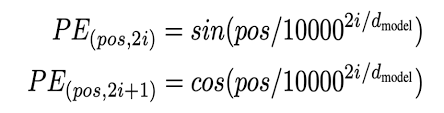


*   Rotary (RoPE) : Son yıllarda LLaMA, DeepSeek gibi modellerde görülmüştür.
Bu Embedding yöntemindeki amaç vektörleri döndürerek göreli açı bilgisini taşımasıdır. Bu sayede metinler uzayın farklı yerlerinde olsalar bile açı sabit kalacağı için uzaklık ve bağlamların aynı olduğu metinler kolaylıkla tespit edilebilir.

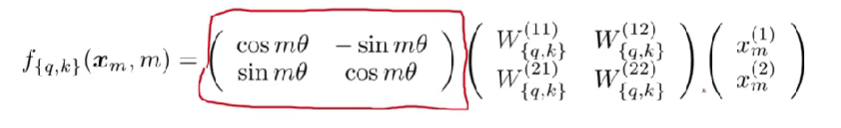

Yukarıdaki formülde kırmızı ile belirtilen kısım döndürme matrisidir. Formülde önemli bir yer oynamaktadır.En sağdaki X matrisi döndürülmeye çalışan vektör iken W matrisi de daha sonra anlatılacak olan Query ve Key matrisleridir.

*  Absolute Learned Embedding: BERT, GPT-2 gibi modellerde klasik yöntem. nn.Embedding(max_len, d_model) gibi. Burada embedding ile metindeki sırası toplanır fakat bu yöntem context_size dan büyük olan metinlerde işe yaramaz ve bağlam çıkaramaz.


*  Relative Positional Encoding: T5, Transformer-XL, DeBERTa gibi modellerde yaygın.“Şu kelime şu konumdan şu kadar uzak” bilgisini modele verir.Sinüsoidal veya trainable olabilir.

##Embedding Kavramı

Embeddingler sayesinde her bir token belirli dimension kadar tensör hale getirilir. LLM'ler için Embedding size genelde vocab_size, output_dim boyutu kadardır.


In [21]:
#Örnek embedding
vocab_size = 6
output_dim = 3
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
torch.manual_seed(25) #Bu hücre her çalıştırıldığında çıktı rastgele olacağından farklı olacaktır. Bunu engellemek için manual_seed kullanılabilir.
embedding_layer.weight

Parameter containing:
tensor([[-0.0614, -0.1687, -1.0408],
        [-0.5413, -0.1960,  0.8578],
        [-0.9257, -1.8566,  0.7273],
        [ 2.9977, -1.8503,  0.2175],
        [-0.7224, -0.4453,  0.3925],
        [-1.1456,  0.3730, -2.3403]], requires_grad=True)

In [22]:
#Embedding layer a bir tensör verilirse indisleri sözlükten çeker.
#Bizim örneğimizde:
#2 → [-0.7860, 0.4670, -1.0564]
#3 → [-0.2387, -1.9087, 1.6108]
#5 → [-1.7176, 0.2078, -0.5758]
#1 → [ 1.2911, -0.1041, -0.6025]
input_ids = torch.tensor([2,3,5,1])
embedding_layer(input_ids)

tensor([[-0.9257, -1.8566,  0.7273],
        [ 2.9977, -1.8503,  0.2175],
        [-1.1456,  0.3730, -2.3403],
        [-0.5413, -0.1960,  0.8578]], grad_fn=<EmbeddingBackward0>)

In [23]:
#GPT embedding
vocab_size = 50257
output_dim = 256
embed_layer = torch.nn.Embedding(vocab_size, output_dim)
embed_layer

Embedding(50257, 256)

In [24]:
max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size = 8, max_length = max_length,
                                  stride = max_length, shuffle = False)

In [25]:
# Here you are trying to access the DataLoader like a list, but it's an iterator.
# You need to get an iterator from the DataLoader and then call next() to get a batch.
data_iter = iter(dataloader)
inputs, targets = first_batch = next(data_iter)
inputs, inputs.shape, targets, targets.shape

(tensor([[   40,   367,  2885,  1464],
         [ 1807,  3619,   402,   271],
         [10899,  2138,   257,  7026],
         [15632,   438,  2016,   257],
         [  922,  5891,  1576,   438],
         [  568,   340,   373,   645],
         [ 1049,  5975,   284,   502],
         [  284,  3285,   326,    11]]),
 torch.Size([8, 4]),
 tensor([[  367,  2885,  1464,  1807],
         [ 3619,   402,   271, 10899],
         [ 2138,   257,  7026, 15632],
         [  438,  2016,   257,   922],
         [ 5891,  1576,   438,   568],
         [  340,   373,   645,  1049],
         [ 5975,   284,   502,   284],
         [ 3285,   326,    11,   287]]),
 torch.Size([8, 4]))

In [26]:
embeds = embed_layer(inputs)
embeds, embeds.shape

(tensor([[[ 5.3937e-01, -8.8458e-01,  1.0683e+00,  ...,  1.6815e+00,
            5.7596e-01,  2.3264e-01],
          [-8.0075e-01, -1.7151e+00, -4.5826e-01,  ...,  8.5064e-01,
           -2.2411e-01, -5.5511e-01],
          [ 4.3994e-01, -1.9114e-01,  2.0582e-01,  ..., -2.9213e-02,
           -9.7628e-01,  1.2485e-01],
          [ 5.2655e-01, -1.2235e-01, -3.8425e-01,  ..., -2.9874e+00,
            4.9615e-01, -5.9820e-01]],
 
         [[ 7.9955e-01,  5.8545e-01, -6.1416e-01,  ..., -2.3237e-01,
           -3.8229e-01,  2.4314e-01],
          [-1.9827e+00,  6.1406e-02,  5.4388e-01,  ..., -1.1623e+00,
            3.1879e-01, -1.1027e+00],
          [ 1.1586e+00, -3.3993e-01, -1.6168e+00,  ..., -9.8203e-01,
           -4.1608e-01,  1.0069e+00],
          [ 3.0416e-01, -6.0033e-01,  1.1287e+00,  ...,  2.7373e-01,
            2.0698e+00,  2.7876e+00]],
 
         [[ 3.8327e-01,  7.8059e-01, -7.9341e-02,  ..., -8.2194e-01,
           -1.0197e-01,  2.8332e-01],
          [ 7.1843e-01,  6.8300

In [27]:
#Positional Embeddingin en ilkel halinde yukarıda da bahsedildiği üzere her bir pozisyon embeddinge eklenir
pos_embeds = embed_layer(torch.arange(max_length))
input_embeddings = embeds + pos_embeds
input_embeddings, input_embeddings.shape

(tensor([[[ 6.2709e-01, -1.4959e+00,  1.4124e+00,  ...,  2.4445e+00,
            8.2561e-01, -3.6534e-01],
          [-1.3943e+00, -1.8001e+00, -2.0934e-01,  ..., -1.8905e-01,
           -4.5606e-02, -8.7279e-01],
          [ 6.1645e-01,  5.7994e-01,  6.0915e-01,  ..., -1.5499e-01,
           -5.8230e-01,  1.0695e+00],
          [ 9.5815e-02, -1.0175e+00, -1.2049e+00,  ..., -2.5072e+00,
           -5.4953e-01, -1.0531e+00]],
 
         [[ 8.8727e-01, -2.5897e-02, -2.7008e-01,  ...,  5.3059e-01,
           -1.3264e-01, -3.5484e-01],
          [-2.5762e+00, -2.3526e-02,  7.9279e-01,  ..., -2.2020e+00,
            4.9730e-01, -1.4204e+00],
          [ 1.3351e+00,  4.3116e-01, -1.2135e+00,  ..., -1.1078e+00,
           -2.2098e-02,  1.9515e+00],
          [-1.2657e-01, -1.4955e+00,  3.0809e-01,  ...,  7.5400e-01,
            1.0241e+00,  2.3327e+00]],
 
         [[ 4.7099e-01,  1.6924e-01,  2.6474e-01,  ..., -5.8985e-02,
            1.4768e-01, -3.1466e-01],
          [ 1.2489e-01, -1.6631

### Self Attention ve MultiHead Attention
Self Attention ve MultiHead Attention kavramları LLM'lerde sıkça kullanılan kavramlardır.
 * Self Attention: Bu kavram bir cümledeki her bir tokenın diğer tokenlarla olan ilişkisini gösterir. Yani bu da demek oluyor ki n tokenlı bir cümledeki self attention matrisimiz nxn boyutlarında olmalıdır.
 Her token için, aynı embedding’den 3 farklı doğrusal dönüşüm uygulanır ve üç vektör elde edilir:

    Query: “Ben kiminle ilgilenmeliyim?”

    Key: “Beni arayanlar beni hangi özelliğimle bulmalı?”

    Value: “Benim taşıdığım bilgi.”

    Benzerlik Skoru: Bunu anlatmadan önce mantığını kavramaya çalışalım. Benzerlik genel olarak matrislerdeki cosinus similarity formülünden gelir. Bu formül de iki matrisin dot product çarpımının 2.dereceden normuna bölünmüş halidir. Dolayısıyla benzerlik skorumuz da bu formülün benzeridir.

    Softmax: Softmax bize olasılık dağılımını ve toplam olasılığın 1'e eşit olmasını sağlar.Skorlar, olasılığa dönüştürülür; her token’ın diğerlerine ne kadar “dikkat” edeceği hesaplanır.

  * MultiHead Attention: Tek bir self-attention katmanı, tek bir “ilişki perspektifi” öğrenir. Ama dilde farklı türde ilişkiler vardır:
  
    Özne–yüklem bağlantısı

    Zaman uyumu

    Anlamsal benzerlik gibi.

Çözüm: Aynı giriş embedding’leri, birden fazla paralel attention “kafasına” (head) gönderilir.Her head’in kendi W_Q, W_K, W_V matrisleri vardır, yani farklı özelliklere odaklanabilir.Bu head’lerin çıktıları birleştirilir (concatenate) ve tek bir doğrusal katmandan geçirilir.Böylece model, aynı anda birçok bağıntıyı görebilir.

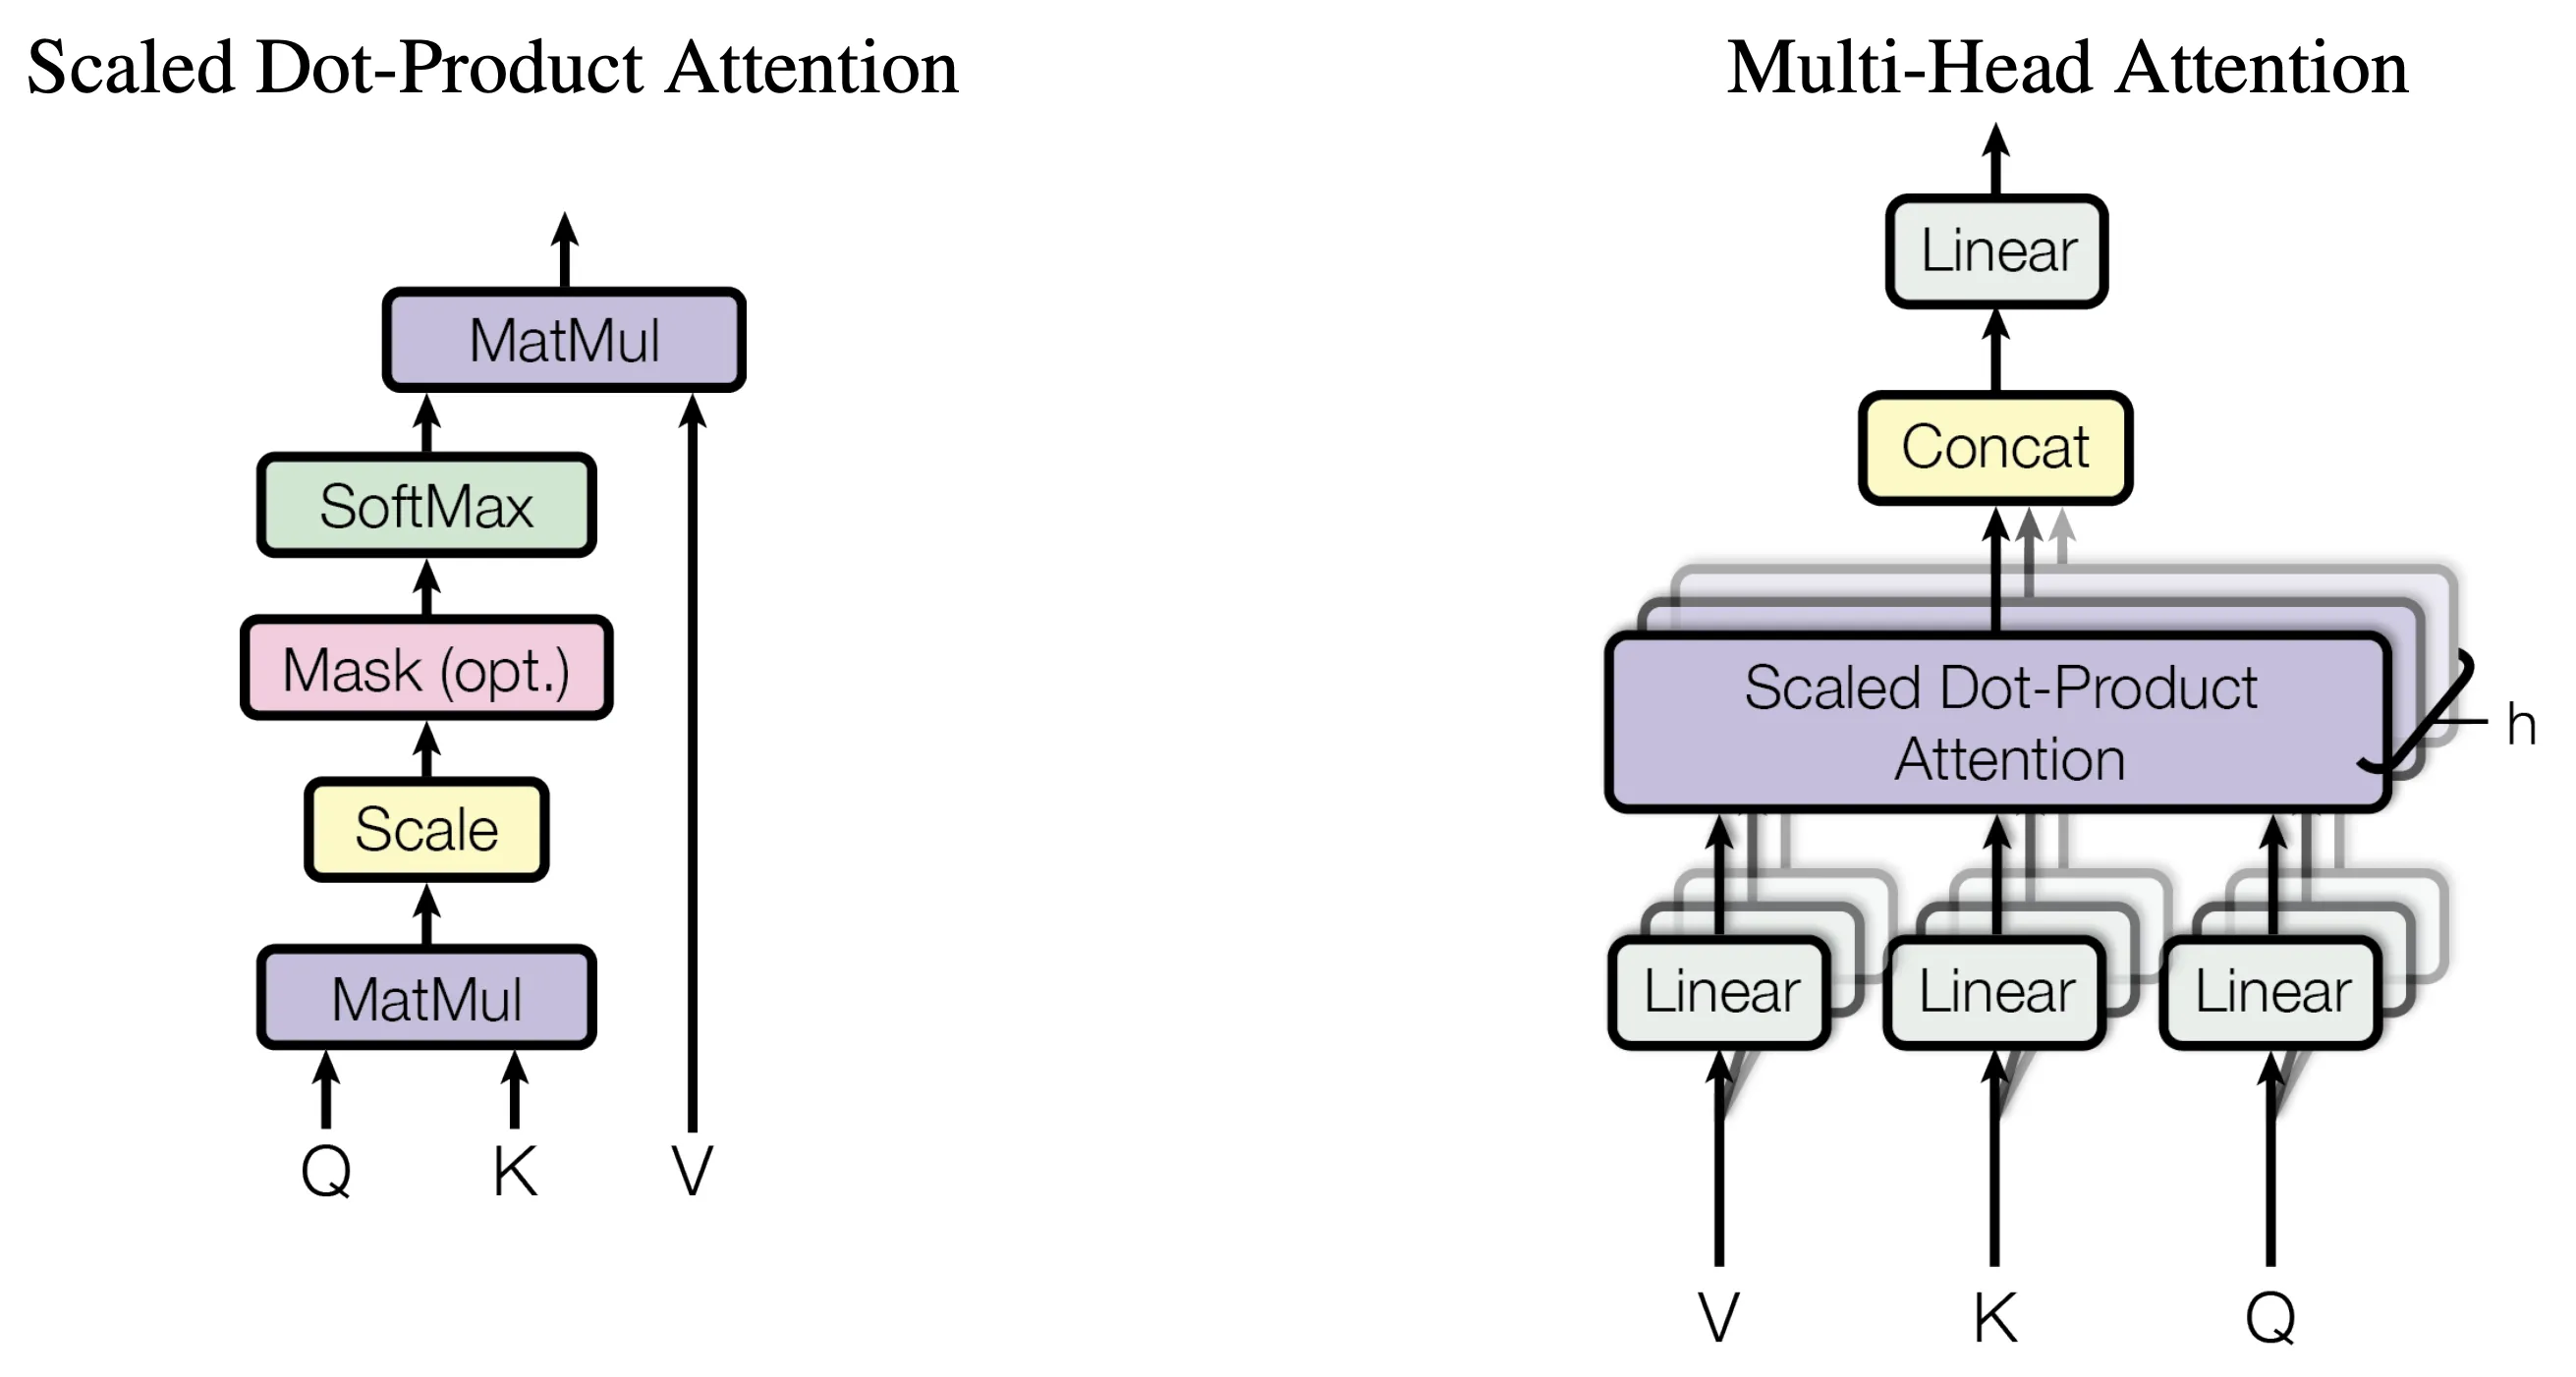

In [28]:
#Bir örnekle konuyu anlayalım.
inputs = torch.tensor([[0.43, 0.15, 0.89], # Bu           (x^1)
                      [0.55, 0.87, 0.66],  # konu         (x^2)
                      [0.57, 0.85, 0.64],  # için         (x^3)
                      [0.22, 0.58, 0.33],  # oluşturulmuş (x^4)
                      [0.77, 0.25, 0.10],  # örnek        (x^5)
                      [0.05, 0.80, 0.55]]) # metindir     (x^6)

key = inputs.clone()
query = inputs.clone()
value = inputs.clone()

attention_scores = query @ key.T
print(f"Attention Scores: {attention_scores}")

attention_weights = torch.softmax(attention_scores, dim=-1)
print(f"Attention Weights: {attention_weights}")

Attention Scores: tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
Attention Weights: tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [29]:
attention_weights.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [30]:
self_attn = attention_weights @ value
print(f"Self Attention: {self_attn}")

Self Attention: tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [31]:
#Burada nn.Parameter yerine nn.Linear yazmak ağırlıkları Xavier/Glorot gibi pratikte daha dengeli çalışan bir ağırlıkla başlatmayı sağlar. Ayrıca bias ekleyebilmeyi, .weight, .bias ile parametreleri kaydetmeyi de sağlar.
class SelfAttention(nn.Module):
  def __init__(self, d_in:int, d_out:int) -> None:
    super().__init__()
    self.w_q = nn.Linear(d_in, d_out, bias = False)
    self.w_k = nn.Linear(d_in, d_out, bias = False)
    self.w_v = nn.Linear(d_in, d_out, bias = False)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    q = self.w_q(x)
    k = self.w_k(x)
    v = self.w_v(x)
    attn_score = q @ k.T
    attn_weights = torch.softmax(attn_score / k.shape[-1] **0.5, dim=-1)
    return attn_weights @ v

In [32]:
torch.manual_seed(123)
d_in = inputs.shape[1]
d_out = 2
sa_v1 = SelfAttention(d_in, d_out)
print(sa_v1(inputs))

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)


In [33]:
queries = sa_v1.w_q(inputs)
keys = sa_v1.w_k(inputs)
attn_scores = queries @ keys.T
print(attn_scores)
attn_weights = torch.softmax(attn_scores / keys.shape[-1] **0.5, dim=-1)
print(attn_weights)

tensor([[0.3111, 0.3479, 0.3471, 0.1714, 0.2350, 0.1928],
        [0.1655, 0.2602, 0.2576, 0.1445, 0.1384, 0.1790],
        [0.1667, 0.2602, 0.2577, 0.1443, 0.1391, 0.1784],
        [0.0510, 0.1080, 0.1064, 0.0643, 0.0476, 0.0835],
        [0.1415, 0.1875, 0.1863, 0.0987, 0.1121, 0.1174],
        [0.0476, 0.1192, 0.1171, 0.0731, 0.0477, 0.0966]],
       grad_fn=<MmBackward0>)
tensor([[0.1717, 0.1762, 0.1761, 0.1555, 0.1627, 0.1579],
        [0.1636, 0.1749, 0.1746, 0.1612, 0.1605, 0.1652],
        [0.1637, 0.1749, 0.1746, 0.1611, 0.1606, 0.1651],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.1632, 0.1674],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.1639],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


Görüldüğü üzere attention skor ve ağırlıkları uyguladıktan sonra d_in = 3 ve d_out = 2 için 6x3 lük bir matris üzerinde nn.Linear işlemi yaptıktan sonra matris çarpımı da devreye girdiği için 6x6'lık bir matris oluştu. Bizim oluşturmamız gereken modelde her bir cümledeki tokenların kendisinden sonraki token bilgilerini bilmemesi gerekmektedir. (Eğer çeviri işlemi için transformer modeli kullanacaksak buradaki Decoder bloklarında ya da BERT modelleri için bu durum bir istisnadır.) Dolayısıyla elde ettiğimiz matrisi maskelememiz gerekecektir. Bu işleme Causal Attention denir. Maskeleme işlemi yapılırken üst üçgeni maskeleyecek bir şekilde matris ayarlanır. Transformer mimarisinden dolayı matrisimiz softmaxten geçeceği için teoride -inf vermemiz gerekse de gerçekte -1e9 gibi büyük bir sayı atarız. Bu da matrisin üst maskesini sıfırlar.

In [34]:
context_length = 6
mask = torch.triu(torch.ones(context_length, context_length), diagonal = 1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.3111,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1655, 0.2602,   -inf,   -inf,   -inf,   -inf],
        [0.1667, 0.2602, 0.2577,   -inf,   -inf,   -inf],
        [0.0510, 0.1080, 0.1064, 0.0643,   -inf,   -inf],
        [0.1415, 0.1875, 0.1863, 0.0987, 0.1121,   -inf],
        [0.0476, 0.1192, 0.1171, 0.0731, 0.0477, 0.0966]],
       grad_fn=<MaskedFillBackward0>)


In [35]:
attn_weigths = torch.softmax(masked / keys.shape[-1] **0.5, dim = -1)
attn_weights

tensor([[0.1717, 0.1762, 0.1761, 0.1555, 0.1627, 0.1579],
        [0.1636, 0.1749, 0.1746, 0.1612, 0.1605, 0.1652],
        [0.1637, 0.1749, 0.1746, 0.1611, 0.1606, 0.1651],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.1632, 0.1674],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.1639],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)

Gelelim çokça kullanılan ancak kimsenin tam olarak %100 bir şekilde ne işe yaradığını bilmediği Dropout katmanına. Bu katman matrisin %p elemanını siler. Kalan elemanları ise 1/(1-p) ile ölçekler.
Örneğin tamamen 1'lerden oluşan bir matrise nn.Dropout(0.5) uygulanırsa matrisin %50'si 0 olur. Kalanlarsa 1 / (1-0.5)'ten 2 olur.

In [36]:
dropout = nn.Dropout(0.5)
ones = torch.ones(6,6)
dropout_matrix = dropout(ones)
print(dropout_matrix)

tensor([[2., 0., 2., 2., 2., 2.],
        [2., 0., 2., 0., 2., 2.],
        [0., 0., 2., 0., 2., 0.],
        [2., 0., 2., 0., 2., 2.],
        [2., 2., 0., 2., 0., 0.],
        [0., 0., 0., 0., 0., 2.]])


In [37]:
class CausalAttention(nn.Module):
  def __init__(self, d_in:int, d_out:int, context_length:int, dropout:float, qkv_bias:bool=False):
    super().__init__()
    self.w_q = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.w_k = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.w_v = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.dropout = nn.Dropout(dropout)
    # Maske uygulamamız lazım. Bu aşamada register_buffer kullanırız. mask öğrenilen bir parametre değildir. Ama modelle birlikte GPU'ya gider.
    self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal = 1))

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    batch_size, num_tokens, d_in = x.shape
    q = self.w_q(x)
    k = self.w_k(x)
    v = self.w_v(x)
    attn_scores = q @ k.transpose(-2, -1) # Corrected: use transpose(-2, -1) instead of .T
    attn_scores = attn_scores.masked_fill(self.mask.bool(), -torch.inf)
    attn_weights = torch.softmax(attn_scores / k.shape[-1] **0.5, dim = -1)
    attn_weights = self.dropout(attn_weights)
    return attn_weights @ v

In [38]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 6, 3])
context_vecs.shape: torch.Size([2, 6, 2])


In [39]:
ca(batch)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)

In [40]:
print(context_vecs)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)


In [41]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in:int, d_out:int, num_heads:int, context_length:int, dropout:float, qkv_bias:bool=False):
    super().__init__()
    self.heads = nn.ModuleList([
        CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)
    ])
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return torch.cat([head(x) for head in self.heads], dim=-1)

In [42]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89],
   [0.55, 0.87, 0.66],
   [0.57, 0.85, 0.64],
   [0.22, 0.58, 0.33],
   [0.77, 0.25, 0.10],
   [0.05, 0.80, 0.55]]
)
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


Neden classları oluştururken nn.Module kullandık diye sorabilirsiniz. Bunun cevabı yine nn.Module içerisinde yer almaktadır. nn.Module kullanıcılara tensörleri cihaza otomatik olarak atma (to(device)), katmanlardaki parametreleri eğitilebilir yaparak güncellenmesini ve kaydedilebilmesini sağlama (nn.Linear(), nn.Dropout() vb.), train moduna ve eval moduna geçişi (.train(), .eval()), eğitilemeyen matrisi buffera alma (register_buffer) gibi bir çok özellik sağlar.

In [43]:
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in = d_in, d_out = d_out, context_length = context_length, dropout = 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


In [44]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in:int, d_out:int, context_length:int, dropout:float, num_heads:int, qkv_bias:bool=False) -> None:
    super().__init__()
    assert(d_out % num_heads == 0), "out boyutu num_heads sayısına tam bölünmelidir..."
    self.head_dim = d_out // num_heads
    self.num_heads = num_heads
    self.d_out = d_out
    self.w_q = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.w_k = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.w_v = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal = 1))

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    batch_size, num_tokens, d_in = x.shape
    q = self.w_q(x)
    k = self.w_k(x)
    v = self.w_v(x)
    q = q.view(batch_size, num_tokens, self.num_heads, self.head_dim).transpose(1,2)
    k = k.view(batch_size, num_tokens, self.num_heads, self.head_dim).transpose(1,2)
    v = v.view(batch_size, num_tokens, self.num_heads, self.head_dim).transpose(1,2)
    attn_scores = q @ k.transpose(-2, -1)
    mask = self.mask[:num_tokens, :num_tokens].unsqueeze(0).unsqueeze(0) #unsqueeze koymasak da çalışır. context_length yerine num_token yazmamızın sebebi context_length > num_token olduğu durumlarda çalışamaz kod. Hedefimiz num_token kadar maskeleme yapmak.
    attn_scores = attn_scores.masked_fill(mask.bool(), -torch.inf)
    attn_weights = torch.softmax(attn_scores / self.head_dim **0.5, dim = -1)
    attn_weights = self.dropout(attn_weights)
    out_tensor = (attn_weights @ v).transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)
    # Burada contiguous çağrısı yapmamızın sebebi transpose, permute gibi işlemlerin tensörün boyutlarını görünürde değiştirir ama genelde hafızadaki fiziksel düzeni değiştirmemesidir. contiguous tensörün bir kopyasını oluşturarak bu değişikliği garanti eder.
    # Sadece view contiguous ister aksi halde hata fırlatır.
    return out_tensor

In [45]:
ma = MultiHeadAttention(d_in = 3, d_out = 2, context_length = 6, dropout = 0.0, num_heads = 2)

In [46]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89],
   [0.55, 0.87, 0.66],
   [0.57, 0.85, 0.64],
   [0.22, 0.58, 0.33],
   [0.77, 0.25, 0.10],
   [0.05, 0.80, 0.55]]
)
batch = torch.stack((inputs, inputs), dim=0)
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2
mha = MultiHeadAttention(d_in = d_in, d_out = d_out, context_length = context_length, dropout = 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5889,  0.0122],
         [-0.6313, -0.0576],
         [-0.5685, -0.0832],
         [-0.5541, -0.0964],
         [-0.5311, -0.1077]],

        [[-0.4519,  0.2216],
         [-0.5889,  0.0122],
         [-0.6313, -0.0576],
         [-0.5685, -0.0832],
         [-0.5541, -0.0964],
         [-0.5311, -0.1077]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


Şimdi sıra modelin önemli parametrelerinden top_p, temperature, top_k gibi parametreleri açıklamaya. Bu parametreler model çıktılarının deterministik (her zaman aynı sonucu veren) olmasını engelleyerek modele belirli bir ölçüde rassallık sağlarlar, modelin belirli olasılık üzerindeki çıktılarını alınmasını sağlarlar ya da belirli olasılık üzerindeki k adet çıktının alınmasını sağlarlar. Gelin her biri ne iş yapıyor inceleyelim.
  * Temperature: Modelin her seferinde deterministik olmayan bir çıktı vermesini sağlar. Hatırlarsanız LLMlerde softmax ile her bir tokenın olasılıksal dağılımının yapıldığından bahsetmiştim. Temperatureda ise softmaxteki elemanlar temperature değerine bölünüyor. Dolayısıyla temperature değeri yüksek çıkarsa çıktılar daha az deterministik, temperature değeri düşükse çıktılar daha deterministik olur.

  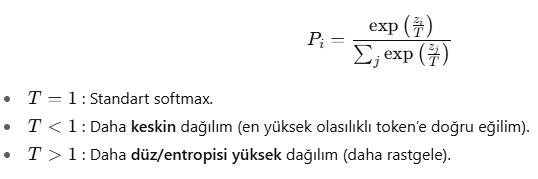

  * Top_k: Softmaxten geçen çıktılar arasında en yüksek olasılığa sahip k adet değerin seçilmesi.

  * Top_p: Seçilen değerlerin toplam olasılıklarının p değerini aşması.

In [47]:
# Bu konuyu anlamak için bir örnek yapalım.
vocab = {
    "Büyük": 0,
    "Dil": 1,
    "Modelleri": 2,
    "üzerine": 3,
    "çalışma": 4,
    "yapıyoruz": 5,
    "ve": 6,
    "mantıklarını": 7,
    "anlıyoruz": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [48]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

# temperature değerini 0.1 yapalım
next_token_logits1 = next_token_logits/0.1
# temperature değerini 5 yapalım
next_token_logits2 = next_token_logits/5
# temperature değerini 100 yapalım
next_token_logits3 = next_token_logits/100

In [49]:
prob1 = torch.softmax(next_token_logits1, dim=0)
prob2 = torch.softmax(next_token_logits2, dim=0)
prob3 = torch.softmax(next_token_logits3, dim=0)
print(f"Temperature: 0.1: {prob1}")
print(f"Temperature: 5: {prob2}")
print(f"Temperature: 100: {prob3}")

Temperature: 0.1: tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])
Temperature: 5: tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])
Temperature: 100: tensor([0.1141, 0.1100, 0.1070, 0.1167, 0.1108, 0.1073, 0.1070, 0.1161, 0.1110])


In [50]:
# Yukarıdaki kodta da görüldüğü üzere temperature değeri küçük olursa olasılıklar arasındaki fark çok belirgin olur, temperature değeri büyük olursa bu fark daha az belirgin olarak deterministikliğin azalmasını sağlar.
# Bu hücrede torch.multinomial ile olasılık dağılımlarımız üzerinde 1 örnek alınmış ve bu örneğin inverse_vocable string karşılığı yazdırılmıştır. temperature değeri küçük olan dağılımda bu hücre ne kadar çalıştırılırsa çalıştırılsın hep olasılığın en büyük çıktığı örnek seçilir yani deterministiklik vardır. Diğer örneklerde bu durum değişebilir.
next_token_id1= torch.multinomial(prob1,num_samples=1).item()
next_token_id2=torch.multinomial(prob2,num_samples=1).item()
next_token_id3 = torch.multinomial(prob3, num_samples=1).item()
print(inverse_vocab[next_token_id1])
print(inverse_vocab[next_token_id2])
print(inverse_vocab[next_token_id3])

üzerine
mantıklarını
ve


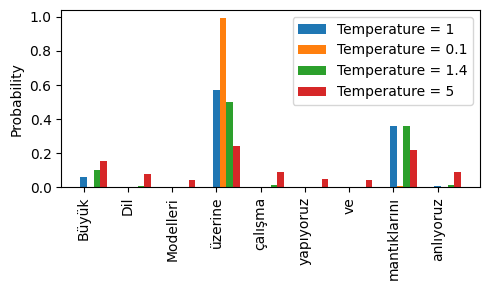

In [51]:
def temperature(logits:torch.Tensor, temperature:float) -> torch.Tensor:
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits, dim = 0)

temperatures = [1, 0.1, 1.4,5]
scaled_probas = [temperature(next_token_logits, temp) for temp in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [52]:
#top_k yi scratch yazalım.
def top_k(logits:torch.Tensor, k:int) -> torch.Tensor:
  logits_list = logits.tolist()
  sorted_logits = sorted(logits_list)[::-1]
  sorted_logits_top_k = sorted_logits[:k]
  indices_top_k = [logits_list.index(i) for i in sorted_logits_top_k]
  return torch.tensor(indices_top_k), torch.tensor(sorted_logits_top_k)

In [53]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
top_indices, top_logits = top_k(next_token_logits, k=3)
print(top_indices)
print(top_logits)

tensor([3, 7, 0])
tensor([6.7500, 6.2800, 4.5100])


In [54]:
# ya da hiç böyle uğraşmayız torch içerisindeki topk yi kullanırız.
top_logits, top_pos = torch.topk(next_token_logits, k=3)
print(top_logits)
print(top_pos)

tensor([6.7500, 6.2800, 4.5100])
tensor([3, 7, 0])


In [55]:
new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float("-inf")),
    other = next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [56]:
top_k_probs = torch.softmax(new_logits, dim = -1)
top_k_probs

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

In [57]:
def generate(idx: torch.Tensor, max_new_tokens: int, top_k: int = None, top_p: float = None, temperature: float = 1.0, eos_id: int = None) -> torch.Tensor:
    for _ in range(max_new_tokens):
        with torch.no_grad():
            logits = model(idx)
            logits = logits[:, -1, :]

        if temperature > 0.0:
            logits = logits / temperature

        if top_k is not None:
            top_logits, top_indices = torch.topk(logits, k=top_k)
            min_val = top_logits[:, -1].unsqueeze(-1)
            logits = torch.where(
                logits < min_val,
                torch.full_like(logits, float("-inf")),
                logits
            )

        if top_p is not None and 0.0 < top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

            sorted_mask = cumulative_probs > top_p
            sorted_mask[:, 1:] = sorted_mask[:, :-1].clone()
            sorted_mask[:, 0] = False

            indices_to_remove = sorted_indices[sorted_mask]
            logits.scatter_(1, indices_to_remove, float('-inf'))

        probs = torch.softmax(logits, dim=-1)
        next_token_id = torch.multinomial(probs, num_samples=1)

        if eos_id is not None and next_token_id.item() == eos_id:
            break

        idx = torch.cat((idx, next_token_id), dim=-1)
    return idx


GPT Mimarisi ile ilgili genel olarak bilgi edindik. Şimdi sıra bildiklerimizi uygulamaya geldi. GPT2 tokenizer'ı hazır olarak geldiği için tokenizer oluşturmayacağız. GPT2 parametreleri ile edindiğimiz bilgiler şu şekilde:

  * vocab_size: 50257    

  * context_length: 1024
  
  * emb_dim: 768

  * n_heads: 12
  
  * n_layers: 12

  * dropout_rate: 0.1

  * qkv_bias: False

In [58]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [59]:
class PositionalEncoding(nn.Module):
  def __init__(self, vocab_size:int, embed_dim:int, dropout:float, context_length:int) -> None:
    super().__init__()
    self.embed_layer = nn.Embedding(vocab_size, embed_dim)
    self.pos_emb = nn.Embedding(context_length, embed_dim)
    self.dropout = nn.Dropout(dropout)
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.dropout(self.embed_layer(x) + self.pos_emb(torch.arange(x.shape[1], device=x.device))) # Added device=x.device

In [60]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in:int, d_out:int, context_length:int, n_heads:int, dropout:float, qkv_bias:bool=False) -> None:
    super().__init__()
    assert d_out % n_heads == 0, "çıkış boyutu head sayısına tam bölünmelidir."
    self.d_h = d_out // n_heads
    self.n_heads = n_heads
    self.d_out = d_out
    self.dropout = nn.Dropout(dropout)
    self.w_q = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.w_k = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.w_v = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    batch_size, num_tokens, d_in = x.shape
    q = self.w_q(x)
    k = self.w_k(x)
    v = self.w_v(x)

    q = q.view(batch_size, num_tokens, self.n_heads, self.d_h).transpose(1,2) # Corrected from diagonal to transpose
    k = k.view(batch_size, num_tokens, self.n_heads, self.d_h).transpose(1,2) # Corrected from diagonal to transpose
    v = v.view(batch_size, num_tokens, self.n_heads, self.d_h).transpose(1,2) # Corrected from diagonal to transpose
    attn_scores = q @ k.transpose(-2, -1)
    masked = self.mask[:num_tokens, :num_tokens].unsqueeze(0).unsqueeze(0)
    attn_scores = attn_scores.masked_fill(masked.bool(), -torch.inf)
    attn_weights = torch.softmax(attn_scores / self.d_h ** 0.5, dim = -1)
    attn_weights = self.dropout(attn_weights)
    out_tensor = (attn_weights @ v).transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)
    # Burada contiguous çağrısı yapmamızın sebebi transpose, permute gibi işlemlerin tensörün boyutlarını görünürde değiştirir ama genelde hafızadaki fiziksel düzeni değiştirmemesidir. contiguous tensörün bir kopyasını oluşturarak bu değişikliği garanti eder.
    # Sadece view contiguous ister aksi halde hata fırlatır.
    return out_tensor

Bu zamana kadar MultiHeadAttention, PositionalEncoding, Tokenizerlara değinmiştik. Farklı olarak LLM'lerde ve genel olarak Transformers mimarisinde FeedForward (İleri Yayılım), ResidualBlocks (Artıklı Bloklar) ve GELU gibi yapıları görebiliriz. Gelin bunların ne olduklarını açıklayalım.
  * Residual Blocks : İlk olarak ResNet mimarisinde karşımıza çıkan bu yapıda girdiler bir sonraki katman çıktısı ile toplanarak hem Vanishing Gradient problemine bir çözüm önerisi olarak karşımıza çıkmıştır hem de işlenmiş ve ham veriler bir arada kullanılarak özellik çıkarımı ve model temsiliyeti sağlanır.

  * GELU(Gaussian Error Linear Unit):Encoder/decoder’daki Feed-Forward Network (FFN) katmanının aktivasyonunda kullanılır. ReLU'nun geleneksel 0'dan büyükse doğrusal davranışı yerine olasılıksal, yumuşak bir aktivasyon sağlar. Bu da Feed-Forward katmanından sonra gelecek olan Softmax için daha düzgün bir aktivasyon sağlar. Ayrıca negatif değerlerin bir kısmını geçirerek ReLU’ya göre daha zengin temsil ve daha iyi gradyan akışı sağlar.

  * Layer Normalization (LayerNorm): Genellikle her sub-layer öncesinde veya sonrasında uygulanır. Özellik boyutunda normalizasyon sağlayarak bir örnek içerisindeki tüm gizli boyuları ortalama 0, varyans 1 olacak şekilde ölçekler. Bu sayede dağılım daha kararlı olur, farklı batch boyutları veya sequence uzunluklarından bağımsız olarak her token vektörü sabit bir ölçeğe gelir. Ayrıca Vanishing Gradient'ın önüne geçilir ve optimizasyon kolaylaşır.

In [61]:
class GELU(nn.Module):
  def __init__(self) -> None:
    super().__init__()
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [62]:
class FeedForward(nn.Module):
  def __init__(self,cfg:dict) -> None:
    super().__init__()
    self.layers= nn.Sequential(
        nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),
        GELU(),
        nn.Linear(4*cfg['emb_dim'],cfg['emb_dim'])
    )
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.layers(x)

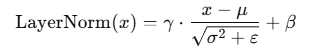


In [63]:
class LayerNorm(nn.Module):
  def __init__(self,emb_dim:int):
    super().__init__()
    self.eps=1e-5
    self.gamma= nn.Parameter(torch.ones(emb_dim))
    self.beta= nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var= x.var(dim=-1,keepdim=True,unbiased =False)
    norm_x= (x - mean)/ torch.sqrt(var+self.eps)
    return self.gamma*norm_x + self.beta

In [64]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg:dict) -> None:
    super().__init__()
    self.mha = MultiHeadAttention(d_in = cfg['emb_dim'],
                                  d_out = cfg['emb_dim'],
                                  context_length = cfg['context_length'],
                                  n_heads = cfg['n_heads'],
                                  dropout = cfg['drop_rate'])
    self.layer_norm1 = LayerNorm(cfg['emb_dim'])
    self.feed_forward = FeedForward(cfg)
    self.layer_norm2 = LayerNorm(cfg['emb_dim'])
    self.dropout = nn.Dropout(cfg['drop_rate'])

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    res = x
    x = self.mha(x)
    x = self.layer_norm1(x)
    x = self.dropout(x)
    x = x + res

    res = x
    x = self.layer_norm2(x)
    x = self.feed_forward(x)
    x = self.dropout(x)
    x = x + res
    return x

In [65]:
class GPT2(nn.Module):
  def __init__(self, cfg:dict) -> None:
    super().__init__()
    self.pos_emb = PositionalEncoding(vocab_size = cfg['vocab_size'],
                                      embed_dim = cfg['emb_dim'],
                                      dropout = cfg['drop_rate'],
                                      context_length = cfg['context_length'])
    self.transformers_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )
    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias = False)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    x = self.pos_emb(x)
    x = self.transformers_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [66]:
gpt2 = GPT2(GPT_CONFIG_124M)
gpt2

GPT2(
  (pos_emb): PositionalEncoding(
    (embed_layer): Embedding(50257, 768)
    (pos_emb): Embedding(1024, 768)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformers_blocks): Sequential(
    (0): TransformerBlock(
      (mha): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (w_q): Linear(in_features=768, out_features=768, bias=False)
        (w_k): Linear(in_features=768, out_features=768, bias=False)
        (w_v): Linear(in_features=768, out_features=768, bias=False)
      )
      (layer_norm1): LayerNorm()
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (mha): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
   

In [67]:
total_params = sum(p.numel() for p in gpt2.parameters()) # gpt2 mimarisindeki bütün katmanlardaki parametreleri toplar.
trainable_params = sum(p.numel() for p in gpt2.parameters() if p.requires_grad == True) # gradyan inişi gerektiren yani eğitilebilir olan parametreleri toplar.

print(f"GPT2 Mimarisi Toplam Parametre Sayısı: {total_params:,}")
print(f"GPT2 Mimarisi Eğitilebilir Toplam Parametre Sayısı: {trainable_params:,}")

GPT2 Mimarisi Toplam Parametre Sayısı: 155,922,432
GPT2 Mimarisi Eğitilebilir Toplam Parametre Sayısı: 155,922,432


In [68]:
# Modelin çalıştığına dair küçük bir test
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Merhaba bu benim ilk denemem"
txt2 = "Model testi başarılı mı"
batch.append(tokenizer.encode(txt1))
batch.append(tokenizer.encode(txt2))
batch = torch.tensor(batch)
batch

tensor([[13102,  5976,    64,   809,  1888,   320,  4229,    74,  2853,   368,
           368],
        [17633,  1332,    72, 26605, 46481,   283, 30102,    75, 30102,   285,
         30102]])

In [69]:
torch.manual_seed(123)
model = GPT2(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[13102,  5976,    64,   809,  1888,   320,  4229,    74,  2853,   368,
           368],
        [17633,  1332,    72, 26605, 46481,   283, 30102,    75, 30102,   285,
         30102]])

Output shape: torch.Size([2, 11, 50257])
tensor([[[ 0.2371, -0.8938,  0.4398,  ..., -0.4068,  0.3566, -1.0514],
         [-0.0682,  0.6041, -0.4903,  ..., -0.8355,  0.4139, -0.5278],
         [-0.0484,  0.5877,  0.3140,  ..., -0.6519, -0.1530, -0.1931],
         ...,
         [-0.3573, -1.2547,  0.2280,  ...,  0.6323, -0.2520, -0.7477],
         [ 0.1089, -0.2574, -0.1621,  ...,  0.2297, -0.8577, -1.4406],
         [-0.1327, -0.1786, -0.0476,  ...,  0.7566,  0.2036, -0.8031]],

        [[-0.2883, -0.0756,  0.5973,  ...,  0.1609, -0.2560, -0.4243],
         [-0.1654, -0.0524, -0.0423,  ...,  0.5907, -0.0418, -0.4281],
         [-0.7828,  0.0747, -0.0559,  ...,  0.0608, -0.3592, -0.3481],
         ...,
         [-0.2865,  0.1255, -0.2469,  ..., -0.3351, -0.7211, -0.2348],
         [ 

In [70]:
def generate_text(model, ids:torch.Tensor, max_new_tokens:int, context_size:int, temperature:float, top_p:float, top_k:int) -> torch.Tensor:
  for _ in range(max_new_tokens):
    ids = ids[:, -context_size:]
    with torch.no_grad():
      logits = model(ids)
    logits = logits[:, -1, :]

    if temperature > 0.0 and temperature < 1.0:
      logits = logits / temperature

    if top_k > 0:
      topk_values, topk_indices = torch.topk(logits, top_k)
      min_value = topk_values.min()
      logits = torch.where(condition = logits < min_value,
                  input = torch.tensor(float('-inf')),
                  other = logits)
    if top_p > 0.0:
      probs = torch.softmax(logits, dim=-1)
      sorted_probs, sorted_indices = torch.sort(probs, descending=True)
      cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
      sorted_mask = cumulative_probs > top_p
      sorted_mask[..., 1:] = sorted_mask[..., :-1].clone()
      sorted_mask[..., 0] = False
      mask = torch.zeros_like(probs, dtype=torch.bool).scatter_(1, sorted_indices, sorted_mask)
      logits = logits.masked_fill(mask, float('-inf'))

    probs = torch.softmax(logits, dim = -1)
    idx_next = torch.multinomial(probs, num_samples = 1)
    ids = torch.cat((ids, idx_next), dim = 1)
  return ids

In [71]:
start_context = "Merhaba bu bir"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [13102, 5976, 64, 809, 35122]
encoded_tensor.shape: torch.Size([1, 5])


In [72]:
model.eval()
out = generate_text(
model=model,
ids=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"],
temperature = 0.5,
top_k = 3,
top_p = 0.7
)
print("Output:", out)
print("Output length:", len(out[0]))


Output: tensor([[13102,  5976,    64,   809, 35122, 46589,  8659, 21413, 42935, 39367,
         44784]])
Output length: 11


In [73]:
decoded_text = tokenizer.decode(out[0].squeeze(0).tolist())
print(decoded_text)

Merhaba bu bir692 sufferangular mockery Minerva ADS


In [74]:
def encode(text:str, tokenizer:tiktoken.core.Encoding) -> list[int]:
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def decode(ids:torch.Tensor, tokenizer:tiktoken.core.Encoding) -> str:
  ids = ids.squeeze(0).tolist()
  decoded = tokenizer.decode(ids)
  return decoded

start_context = 'Every effort moves you'
token_ids = generate_text(
    model = model,
    ids = encode(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M['context_length'],
    temperature = 0.5,
    top_k = 3,
    top_p = 0.7
)
print(decode(token_ids, tokenizer))

Every effort moves you he breaking disruptedOWS Establishmentub buy Rally Vikvi


In [75]:
class GPTDataset(Dataset):
  def __init__(self, text:str, tokenizer:tiktoken.core.Encoding, context_length:int, stride:int) -> None:
    super().__init__()
    self.token_ids = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    self.input_ids = []
    self.target_ids = []
    for i in range(0, len(self.token_ids) - context_length, stride):
      inp_chunks = self.token_ids[i:i+context_length]
      tar_chunks = self.token_ids[i+1:i+context_length+1]
      self.input_ids.append(torch.tensor(inp_chunks))
      self.target_ids.append(torch.tensor(tar_chunks))
  def __len__(self) -> int:
    return len(self.input_ids)

  def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
     return self.input_ids[idx], self.target_ids[idx]

def create_dataloader(txt:str, num_workers:int, batch_size:int=4, max_length:int=256,
                      stride:int=128, shuffle:bool=True):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDataset(txt, tokenizer, max_length, stride)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
  return dataloader

In [76]:
text_data = raw_text
total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))

train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"] // 4,
    stride=GPT_CONFIG_124M["context_length"] // 4,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"] // 4,
    stride=GPT_CONFIG_124M["context_length"] // 4,
    shuffle=False,
    num_workers=0
)

In [77]:
# Eğer toplam tokenın train_ratio ile çarpılmış hali bizim parametremizdeki context_length e eşit değilse ya biraz fazla veri toplamalıyız ya da context_length i düşürmeliyiz. Bizim verimiz az olduğu için dataloader oluştururken değer çeyreğine düşürüldü.
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("training_loader için yeterli token yok. "
          "GPT_CONFIG_124M['context_length'] değerini düşür ya da training_ratio'yu arttır")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("validation_loader için yeterli token yok. "
          "`GPT_CONFIG_124M['context_length']` değerini düşür ya da training_ratio'yu arttır.")

validation_loader için yeterli token yok. `GPT_CONFIG_124M['context_length']` değerini düşür ya da training_ratio'yu arttır.


In [78]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [79]:
def eval_llm(model, val_dataloader, loss, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for input, target in val_dataloader:
            input  = input.to(device)
            target = target.to(device)
            output = model(input)
            batch_loss = loss(
                output.view(-1, output.shape[-1]),
                target.view(-1)
            )
            total_loss += batch_loss.item()
    avg_val_loss = total_loss / len(val_dataloader)
    return avg_val_loss


def train_llm(model, train_dataloader, val_dataloader, loss, optimizer, device, epochs):
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        for input, target in train_dataloader:
            input  = input.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(input)
            batch_loss = loss(
                output.view(-1, output.shape[-1]),
                target.view(-1)
            )
            batch_loss.backward()
            optimizer.step()
            total_train_loss += batch_loss.item()
        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_val_loss = eval_llm(model, val_dataloader, loss, device)

        print(
            f"Epoch {epoch+1:03d}/{epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f}"
        )

    torch.save(model.state_dict(), "gpt2.pth")


In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_llm(model,
          train_loader,
          val_loader,
          loss=nn.CrossEntropyLoss(),
          optimizer=torch.optim.AdamW(params=model.parameters(), lr = 1e-3),
          device=device,
          epochs=100)

Epoch 001/100 | Train Loss: 8.5152 | Val Loss: 6.8172
Epoch 002/100 | Train Loss: 6.3824 | Val Loss: 6.8369
Epoch 003/100 | Train Loss: 6.2180 | Val Loss: 6.9044
Epoch 004/100 | Train Loss: 6.0791 | Val Loss: 6.9260
Epoch 005/100 | Train Loss: 5.8853 | Val Loss: 6.8618
Epoch 006/100 | Train Loss: 6.3827 | Val Loss: 6.8019
Epoch 007/100 | Train Loss: 5.9601 | Val Loss: 6.7719
Epoch 008/100 | Train Loss: 5.8625 | Val Loss: 6.7611
Epoch 009/100 | Train Loss: 5.7395 | Val Loss: 6.6227
Epoch 010/100 | Train Loss: 5.6012 | Val Loss: 6.7023
Epoch 011/100 | Train Loss: 5.4245 | Val Loss: 6.7395
Epoch 012/100 | Train Loss: 5.2456 | Val Loss: 6.7066
Epoch 013/100 | Train Loss: 4.9242 | Val Loss: 6.6503
Epoch 014/100 | Train Loss: 4.4410 | Val Loss: 6.6289
Epoch 015/100 | Train Loss: 4.0512 | Val Loss: 6.7026
Epoch 016/100 | Train Loss: 3.6466 | Val Loss: 6.7326
Epoch 017/100 | Train Loss: 3.1227 | Val Loss: 6.8069
Epoch 018/100 | Train Loss: 2.5366 | Val Loss: 7.0577
Epoch 019/100 | Train Loss: 

Elimizdeki veri senaryosuna göre overfit beklediğimiz bir durumdu. Çünkü validation kısmında zaten yeterlice veri yoktu ve model parametresine göre eğitilecek veri zaten azdı. (150 küsür milyon parametre için 4000 5000 arası token vardı.) Ancak veri seti çok genişletilirse alınan sonuçlar daha tutarlı olacaktır.

In [81]:
model_trained = GPT2(GPT_CONFIG_124M)
model_trained.load_state_dict(torch.load("/content/gpt2.pth", weights_only=True))

<All keys matched successfully>

In [82]:
text_1 = 'That is'
token_ids = generate_text(
    model = model_trained,
    ids = encode(text_1, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M['context_length'],
    temperature = 0.5,
    top_k = 3,
    top_p = 0.7

)

In [83]:
token_ids

tensor([[ 2504,   318,  8737,   656, 19133,   553,   373,   530,   286,   262,
          7877,    72]])

In [84]:
tokenizer.decode(token_ids[0].squeeze(0).tolist())

'That is beauty into circulation," was one of the axi'

Baştan sona GPT2 mimarisini oluşturmayı öğrendik ancak kısıtlı veride eğitim gerçekleştirdiğimiz için model sonuçlarımız pek de iyi olmadı. Bunun önüne geçmek için daha önceden büyük veriyle eğitilmiş ve Transformers kütüphanesine eklenmiş halini kullanalım. Bu bize zamandan ve kaynaktan tasarruf sağlar.

In [85]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [86]:
text = "My name is"
encoded_input = tokenizer(text, return_tensors='pt')
generated_text = tokenizer.decode(model.generate(encoded_input['input_ids'], max_new_tokens = 9)[0])
generated_text

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


"My name is John. I'm a man of God."

BONUS: GPT2 modeli üzerinde spam ve spam olmayan SMS verisi eğitimi.

Veriyi yüklemek için:

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

Colab eğitim ortamında nispeten kısıtlı GPU sunar. Bundan dolayı eğitim aşaması Kaggle'da gerçekleştirilmiştir.

Kaggle Çalışması: https://www.kaggle.com/code/s7522k/gpt2-finetuning-sms-dataset